<center><h1>Supplemental Material</h1></center>

<br>
<center><h2>Simple and exact nonlinear pendulum motion for all possible initial conditions</h2></center>

Teepanis Chachiyo <teepanisc@nu.ac.th>
Department of Physics, Faculty of Science, Naresuan University, Phitsanulok 65000, Thailand.


### Available at a GitHub repository: [https://github.com/teepanis/nonlinear-pendulum](https://github.com/teepanis/nonlinear-pendulum)




## This Work $\theta(t)$

These python codes compute angular displacement $\theta(t)$ of the nonlinear pendulum using exact solution derived in this work as described in the paper. The main subroutines are:

1. **theta**(theta0, omega0, t, ...)
2. **phase**(theta0, omega0, ...)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def K(k):
    # scipy defines K differently, so that we need to pass k**2 insead of k
    return sp.special.ellipk(k**2)
    
# compute magnitude of omegaM
def get_omegaM(theta0, omega0, OmegaL):
    return np.sqrt(omega0**2 - 2*np.cos(theta0)*OmegaL**2 + 2*OmegaL**2)

# compute magnitude of omega0, basically inverse of above
def get_omega0(theta0, omegaM, OmegaL):
    return np.sqrt(omegaM**2 + 2*np.cos(theta0)*OmegaL**2 - 2*OmegaL**2)

#
# compute phase shift
#
def phase(theta0, omega0, OmegaL, cutoff=1e-8, maxN=200):
    
    # special cases
    if theta0 == 0.0: return 0.0
    if omega0 == 0.0:
        if theta0 > 0: return +np.pi/2
        else: return -np.pi/2

    omegac = 2*OmegaL
    omegaM = get_omegaM(theta0, omega0, OmegaL)
    k = omegaM/omegac
    
    # swinging motion
    if k < 1:
                
        # compute coefficient an
        T = 4*K(k)/OmegaL
        Omega0 = 2*np.pi/T
        kappa = K(np.sqrt(1-k**2))

        a = np.zeros(maxN)
        for n in range(1,maxN,2):
            a[n] = 4/n/np.cosh(kappa*n*Omega0/OmegaL)

        def f(delta):
            s = 0
            for n in range(1,maxN,2): s = s + a[n]*np.sin(n*delta)
            return theta0 - s

        def fp(delta):
            s = 0
            for n in range(1,maxN,2): s = s + n*a[n]*np.cos(n*delta)
            return -s

        # initial guess
        delta = np.arcsin(theta0/a[1])

        # update
        while True:
            step = - f(delta)/fp(delta)
            delta = delta + step
            if np.abs(step) < cutoff: break
                
    # stopping motion
    elif k == 1:
        x = np.sin(theta0/2)
        delta = 1/2*np.log((1+x)/(1-x))
        
    # spining motion
    else:
        
        # compute coefficients
        T = 2/k*K(1/k)/OmegaL
        Omega0 = 2*np.pi/T
        kappa = 1/k*K(np.sqrt(1-1/k**2))        
            
        b = np.zeros(maxN)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(kappa*n*Omega0/OmegaL)

        def f(delta):
            s = 0
            for n in range(1,maxN,1): s = s + b[n]*np.sin(n*delta)
            return theta0 - delta - s

        def fp(delta):
            s = 0
            for n in range(1,maxN,1): s = s + n*b[n]*np.cos(n*delta)
            return -1-s
        
        # initial guess
        delta = theta0/(1+b[1])

        # update
        while True:
            step = - f(delta)/fp(delta)
            delta = delta + step
            if np.abs(step) < cutoff: break

    return delta

##
## compute angular displacement
##
def theta(theta0, omega0, t, OmegaL, maxN=200):
    
    theta = np.zeros(len(t))
    
    omegac = 2*OmegaL
    omegaM = get_omegaM(theta0, omega0, OmegaL)
    k = omegaM/omegac

    # For omega0 < 0, use mirror symmetry
    if omega0 < 0:
        theta0 = -theta0
        omega0 = -omega0
        mirror = True
    else:
        mirror = False
        
    # compute phase constant
    delta = phase(theta0, omega0, OmegaL, 1e-8, maxN)
    
    # swinging motion
    if k < 1:

        # compute period
        T = 4*K(k)/OmegaL
        Omega0 = 2*np.pi/T

        # compute coefficients
        a = np.zeros(maxN)
        kappa = K(np.sqrt(1-k**2))
        for n in range(1,maxN,2):
            a[n] = 4/n/np.cosh(kappa*n*Omega0/OmegaL)
        
        # sum contributions at time t
        for i in range(len(t)):
            s = 0
            for n in range(0,maxN): s = s + a[n]*np.sin(n*Omega0*t[i] + n*delta)
            theta[i] = s
    
    # stopping motion
    elif k == 1:
        for i in range(len(t)):
            theta[i] = 2*np.arcsin( np.tanh(OmegaL*t[i] + delta) )
    
    # spinning motion
    else:
        # compute period
        T = 2/k*K(1/k)/OmegaL
        Omega0 = 2*np.pi/T
        
        # compute coefficients
        b = np.zeros(maxN)
        kappa = 1/k*K(np.sqrt(1-1/k**2))
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(kappa*n*Omega0/OmegaL)
        
        # sum contributions at time t + 
        for i in range(len(t)):
            s = 0
            for n in range(0,maxN): s = s + b[n]*np.sin(n*Omega0*t[i] + n*delta)
            theta[i] = Omega0*t[i] + delta + s

    if mirror == True: return -theta
    else: return theta


<div style="page-break-after: always;"></div>

## Results

### Figure 1: Angular Displacement

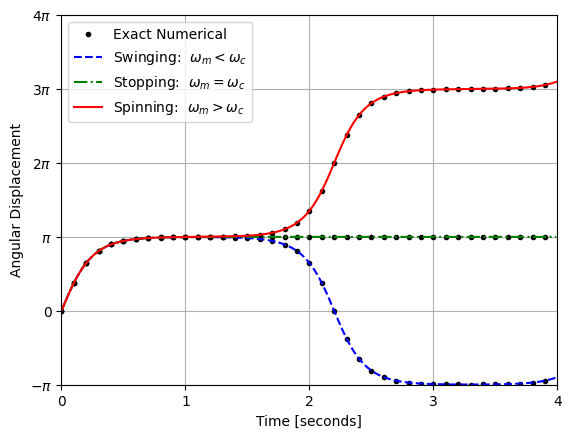

Maximum |Deviation|:  6.17284001691587e-14
Maximum |Deviation|:  0.0
Maximum |Deviation|:  5.329070518200751e-15


In [2]:
g = 9.8
L = g/4/np.pi**2
OmegaL = np.sqrt(g/L)

def theta_Jacobi(omegaM, t):

    E = (1/2*omegaM**2)*L/g
    k = np.sqrt(L/g)*omegaM/2
    theta = np.zeros(len(t))
    
    for i in range(len(t)):
        
        if omegaM < omegac:
            [sn, cn, dn, ph] = sp.special.ellipj(np.sqrt(g/L)*t[i], k**2)
            theta[i] = 2*np.arcsin(k*sn)
        elif omegaM == omegac:
            # using a known property of Jacobi sine function for modulus = 1
            # numerical method is less accurate when modulus = 1, see SciPy document
            sn = np.tanh(np.sqrt(g/L)*t[i])
            theta[i] = 2*np.arcsin(k*sn)
        else:
            [sn, cn, dn, ph] = sp.special.ellipj(np.sqrt(g/L)*t[i]*np.sqrt(E/2), 
                                                 np.sqrt(2/E)**2)
            theta[i] = 2*ph
        
    return theta

omegac = 2*OmegaL

Tmax = 4
t = np.arange(0, Tmax, 0.01)

plt.plot(t, theta_Jacobi(omegac-0.0001,t),'k.',markevery=10,label='Exact Numerical')
plt.plot(t, theta_Jacobi(omegac,t),'k.',markevery=10)
plt.plot(t, theta_Jacobi(omegac+0.0001,t),'k.',markevery=10)

plt.plot(t, theta(0,omegac-0.0001,t,OmegaL),'b--',label='Swinging:  $\\omega_m < \\omega_c$')
plt.plot(t, theta(0,omegac,t,OmegaL),'g-.',label='Stopping:  $\\omega_m = \\omega_c$')
plt.plot(t, theta(0,omegac+0.0001,t,OmegaL),'r-', label='Spinning:  $\\omega_m > \\omega_c$')
plt.ylim(-np.pi,4*np.pi)
plt.xlim(0,Tmax)
plt.yticks([-np.pi,0,np.pi,2*np.pi,3*np.pi,4*np.pi],
           ['$-\pi$','0','$\pi$','$2\pi$','$3\pi$','$4\pi$'])
plt.xticks([0,1,2,3,4])
plt.grid()
plt.legend()
plt.xlabel('Time [seconds]')
plt.ylabel('Angular Displacement')
#plt.savefig('fig_3classes.pdf')
plt.show()

print("Maximum |Deviation|: ", 
      max(abs(theta(0,omegac-0.0001,t,OmegaL)-
              theta_Jacobi(omegac-0.0001,t))))
print("Maximum |Deviation|: ", 
      max(abs(theta(0,omegac,t,OmegaL)-
              theta_Jacobi(omegac,t))))

print("Maximum |Deviation|: ", 
      max(abs(theta(0,omegac+0.0001,t,OmegaL)-
              theta_Jacobi(omegac+0.0001,t))))

<div style="page-break-after: always;"></div>

### Section 2.2 Phase Constant $\delta$

Illustrate special cases of $\delta$ as mentioned in the main text.

In [3]:
# i) theta0 = 0
delta = phase(0,1, OmegaL)
print('  i) phase / PI = ', delta/np.pi)

# ii) theta0 > 0, omega0 = 0
delta = phase(1,0, OmegaL)
print(' ii) phase / PI = %+.1f' % (delta/np.pi))

# iii) theta0 < 0, omega0 = 0
delta = phase(-1,0, OmegaL)
print('iii) phase / PI = %+.1f' % (delta/np.pi))

  i) phase / PI =  0.0
 ii) phase / PI = +0.5
iii) phase / PI = -0.5


<div style="page-break-after: always;"></div>

### Figure 2: Solutions with Phase Shift

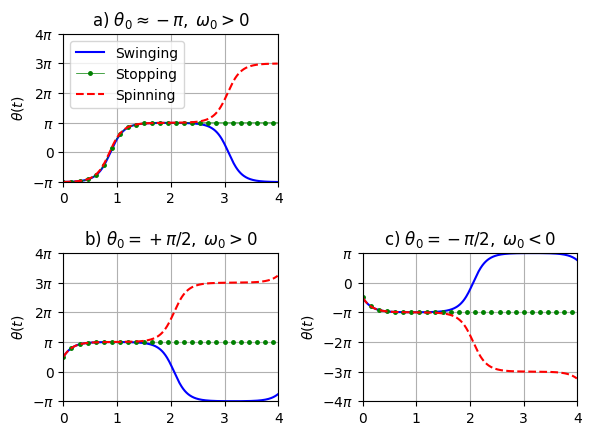

In [4]:
import numpy as np
import matplotlib.pyplot as plt

omegac = 2*OmegaL

Tmax = 4
t = np.arange(0,Tmax,0.01)

# a) theta0 near -pi, omega0 > 0
theta0 = -179/180*np.pi
omega0_swinging = get_omega0(theta0, omegac-0.0001,  OmegaL)
omega0_stopping = get_omega0(theta0, omegac       ,  OmegaL)
omega0_spinning = get_omega0(theta0, omegac+0.0001,  OmegaL)
theta_swinging_a = theta(theta0, omega0_swinging, t, OmegaL)
theta_stopping_a = theta(theta0, omega0_stopping, t, OmegaL)
theta_spinning_a = theta(theta0, omega0_spinning, t, OmegaL)

# b) theta0 = pi/2, omega0 > 0
theta0 = np.pi/2
omega0_swinging = get_omega0(theta0, omegac-0.0001,  OmegaL)
omega0_stopping = get_omega0(theta0, omegac      ,   OmegaL)
omega0_spinning = get_omega0(theta0, omegac+0.0001,  OmegaL)
theta_swinging_b = theta(theta0, omega0_swinging, t, OmegaL)
theta_stopping_b = theta(theta0, omega0_stopping, t, OmegaL)
theta_spinning_b = theta(theta0, omega0_spinning, t, OmegaL)

# c) theta0 = -pi/2, omega0 < 0
theta0 = -np.pi/2
theta_swinging_c = theta(theta0, -omega0_swinging, t, OmegaL)
theta_stopping_c = theta(theta0, -omega0_stopping, t, OmegaL)
theta_spinning_c = theta(theta0, -omega0_spinning, t, OmegaL)

fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=3)

ax[0,0].set_title('a) $\\theta_0 \\approx -\pi,\\; \\omega_0 > 0$')
ax[0,0].plot(t, theta_swinging_a,'b-',label='Swinging')
ax[0,0].plot(t, theta_stopping_a,'g.-', linewidth=0.5, 
             markersize=5, markevery=15, label='Stopping')
ax[0,0].plot(t, theta_spinning_a,'r--', label='Spinning')

ax[1,0].set_title('b) $\\theta_0 =+\pi/2,\\; \\omega_0 > 0$')
ax[1,0].plot(t, theta_swinging_b,'b-')
ax[1,0].plot(t, theta_stopping_b,'g.', markersize=5, markevery=15)
ax[1,0].plot(t, theta_spinning_b,'r--')

ax[1,1].set_title('c) $\\theta_0 =-\pi/2,\\; \\omega_0 < 0$')
ax[1,1].plot(t, theta_swinging_c,'b-')
ax[1,1].plot(t, theta_stopping_c, 'g.',markersize=5, markevery=15)
ax[1,1].plot(t, theta_spinning_c,'r--')

for i in range(0,2):
    for j in range(0,2):

        ax[i,j].set_ylim(-np.pi,4*np.pi)
        ax[i,j].set_xlim(0,Tmax)
        ax[i,j].set_yticks([-np.pi,0,np.pi,2*np.pi,3*np.pi,4*np.pi],
                   ['$-\pi$','0','$\pi$','$2\pi$','$3\pi$','$4\pi$'])
        ax[i,j].set_xticks([0,1,2,3,4])
        ax[i,j].grid()
        #ax[i,j].legend()
        #ax[i,j].set_xlabel('Time [seconds]')
        ax[i,j].set_ylabel('$\\theta(t)$')

ax[0,0].legend()
ax[1,1].set_ylim(-4*np.pi,np.pi)
ax[1,1].set_yticks([-4*np.pi,-3*np.pi,-2*np.pi,-np.pi,0,np.pi],
                   ['$-4\pi$','$-3\pi$','$-2\pi$','$-\pi$','$0$','$\pi$'])

#ax[1,1].plot([0,4],[0,0],'k-')
#ax[1,0].plot([0,4],[0,0],'k-')

ax[0,1].set_axis_off()

#plt.savefig('fig_phase_shift.svg',transparent=True)
plt.show()

<div style="page-break-after: always;"></div>

## Discussions

### Figure 3: Frequencies Analysis

A swinging and spinning pendulum with $\theta_0 = 0$ and $\omega_0 = \omega_c \pm 0.0001$, basically the same condition as in Fig 1., is simulated.

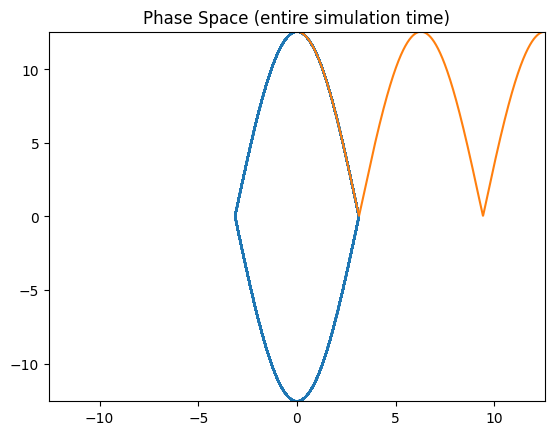

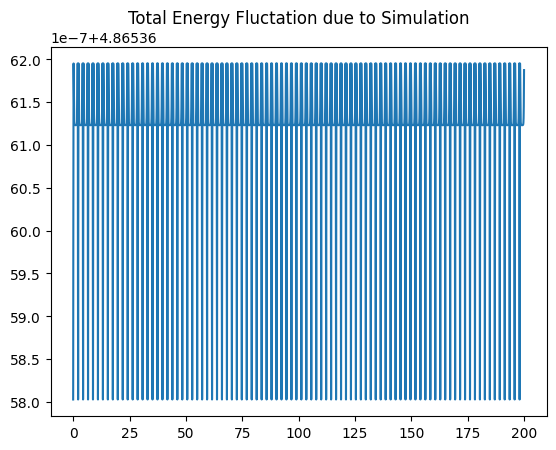

In [5]:
m = 1.0
g = 9.8
L = g/4/np.pi**2

# Linear angular frequency of a pendulum
OmegaL = np.sqrt(g/L)

def simulate(theta0, omega0, Tmax=2000, dt=0.001):
    
    t = np.arange(0,Tmax,dt)
    maxN = len(t)
    theta = np.zeros(maxN)
    omega = np.zeros(maxN)

    # initial condition
    theta[0] = theta0
    omega[0] = omega0

    # define acceleraton
    def a(theta,omega,t):
        return -g/L*np.sin(theta)
        
    
    for i in range(1, maxN):

        # Euler-Cromer
        #omega[i] = omega[i-1] + a(theta[i-1],omega[i-1],t[i-1])*dt
        #theta[i] = theta[i-1] + omega[i]*dt

        # Velocity Verlet
        theta[i] = theta[i-1] + omega[i-1]*dt + 1/2*a(theta[i-1],omega[i-1],t[i-1])*dt**2
        omega[i] = omega[i-1] + (a(theta[i-1],omega[i-1],t[i-1])+a(theta[i],omega[i],t[i]))/2*dt

    return t, theta, omega

Tmax = 200

##
## Collect data for swinging and spinning motion
##
omegac = 2*OmegaL
omegaM = omegac-0.0001
t, theta_swinging, omega_swinging = simulate(0, omegaM, Tmax, dt=0.0001)
omegaM = omegac+0.0001
t, theta_spinning, omega_spinning = simulate(0, omegaM, Tmax, dt=0.0001)

N = len(t)
#plt.plot(t[0:N//10], theta_swinging[0:N//10])
#plt.plot(t[0:N//10], theta_spinning[0:N//10])
#plt.title('$\\theta(t)$ (first 10% of max time)')
#plt.show()
#plt.plot(t[0:N//10], omega_swinging[0:N//10])
#plt.plot(t[0:N//10], omega_spinning[0:N//10])
#plt.title('$\\omega(t)$ (first 10% of max time)')
#plt.show()
plt.plot(theta_swinging,omega_swinging)
plt.plot(theta_spinning,omega_spinning)
plt.title('Phase Space (entire simulation time)')
plt.xlim(-4*np.pi,+4*np.pi)
plt.ylim(-4*np.pi,+4*np.pi)
plt.show()

##
## Check total energy fluctuation
##
I = m*L**2
Ec = 1/2*I*omegac**2
E_swinging  = 1/2*I*omega_swinging**2 - m*g*L*np.cos(theta_swinging) + m*g*L

plt.plot(t, E_swinging)
plt.title('Total Energy Fluctation due to Simulation')
plt.show()

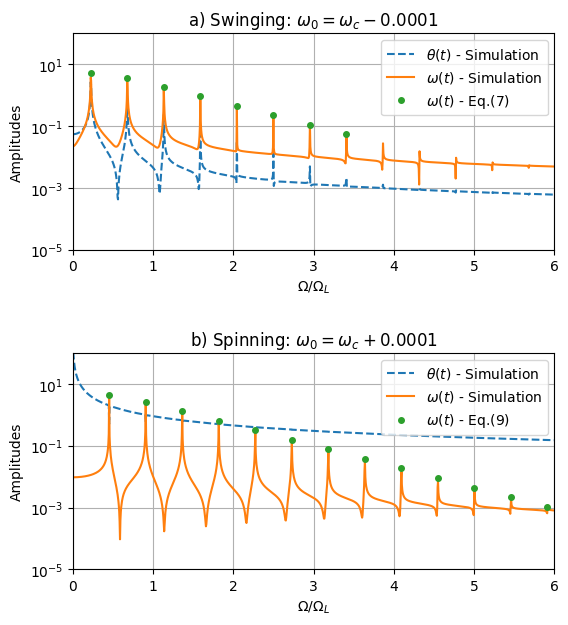

In [6]:
## Fourier transform
THETA_swinging = sp.fft.fft(theta_swinging)
OMEGA_swinging = sp.fft.fft(omega_swinging)

THETA_spinning = sp.fft.fft(theta_spinning)
OMEGA_spinning = sp.fft.fft(omega_spinning)

Omega = 2*np.pi*N/Tmax*sp.fft.fftfreq(N)[:N//2]

fig, ax = plt.subplots(2)
fig.tight_layout(pad=3)
fig.set_size_inches(6, 7)

ax[0].set_title('a) Swinging: $\\omega_0 = \\omega_c-0.0001$')
ax[0].plot(Omega/OmegaL, 2/N*np.abs(THETA_swinging[0:N//2]),'--',label='$\\theta(t)$ - Simulation')
ax[0].plot(Omega/OmegaL, 2/N*np.abs(OMEGA_swinging[0:N//2]),'-',label='$\\omega(t)$ - Simulation')

ax[1].set_title('b) Spinning: $\\omega_0 = \\omega_c+0.0001$')
ax[1].plot(Omega/OmegaL, 2/N*np.abs(THETA_spinning[0:N//2]),'--',label='$\\theta(t)$ - Simulation')
ax[1].plot(Omega/OmegaL, 2/N*np.abs(OMEGA_spinning[0:N//2]),'-',label='$\\omega(t)$ - Simulation')

## theoretical omega coefficients
def theoretical_freq_domain(omegaM):
    
    omegac = 2*OmegaL
    k = omegaM/omegac
    maxN = 17
    if k < 1:
        kappa = K(np.sqrt(1-k**2))
        T = 4*K(k)/OmegaL
        Omega0 = 2*np.pi/T
        a = np.zeros(maxN)
        W = np.zeros(maxN)
        for n in range(1,maxN,2):
            a[n] = 4/n/np.cosh(kappa*n*Omega0/OmegaL)
            W[n] = n*a[n]*Omega0        
    elif k > 1:
        kappa = 1/k*K(np.sqrt(1-1/k**2))
        T = 2/k*K(1/k)/OmegaL
        Omega0 = 2*np.pi/T
        b = np.zeros(maxN)
        W = np.zeros(maxN)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(kappa*n*Omega0/OmegaL)
            W[n] = n*b[n]*Omega0

    Omega_Theory = np.zeros(maxN)
    for i in range(0,maxN): Omega_Theory[i] = i*Omega0

    return Omega_Theory, W

omegac = 2*OmegaL
omegaM = omegac-0.0001
Omega_Theory, W = theoretical_freq_domain(omegaM)
ax[0].plot(Omega_Theory/OmegaL, W, '.', markersize=8, label='$\\omega(t)$ - Eq.(7)')

omegaM = omegac+0.0001
Omega_Theory, W = theoretical_freq_domain(omegaM)
ax[1].plot(Omega_Theory/OmegaL, W, '.', markersize=8, label='$\\omega(t)$ - Eq.(9)')

for i in range(0,2):    
    ax[i].set_xlabel('$\\Omega/\\Omega_L$')
    ax[i].set_ylabel('Amplitudes')
    ax[i].set_xlim(0,6)
    ax[i].set_ylim(1e-5,1e2)
    ax[i].grid()
    ax[i].set_yscale('log')
    ax[i].legend()

#plt.savefig('fig_frequencies.pdf')
plt.show()


<div style="page-break-after: always;"></div>

## Comparison to Perturbation Theory

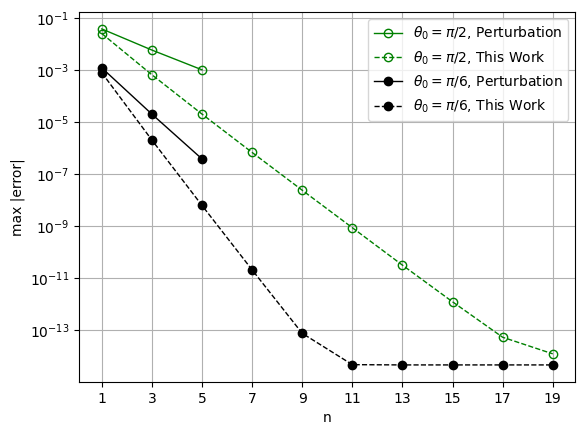

In [7]:
def theta_perturb(order, theta0, t, Omega0):

    theta = np.zeros(len(t))
    
    # add all perturbative contributions
    if order == 1:
        A1 = +(theta0)
        A3 = 0
        A5 = 0
    if order == 3:
        A1 = +(theta0 + 1/192*theta0**3)
        A3 = -(1/192*theta0**3)
        A5 = 0
    if order == 5:
        A1 = +(theta0 + 1/192*theta0**3 + 17/120/512*theta0**5)
        A3 = -(1/192*theta0**3 + 1/6/512*theta0**5)
        A5 = +(1/40/512*theta0**5)
        
    theta = A1*np.cos(Omega0*t) + A3*np.cos(3*Omega0*t) + A5*np.cos(5*Omega0*t)
    
    return theta

Tmax = 4
t = np.arange(0, Tmax, 0.01)

def err_profile(theta0, N):

    # swinging motion
    omega0 = 0
    omegaM = get_omegaM(theta0, omega0, OmegaL)
    k = omegaM/omegac
    T = 4*K(k)/OmegaL
    Omega0 = 2*np.pi/T

    # maximum |error|
    merr_perturb = np.zeros(3)
    merr_perturb[0] = max(np.abs(theta_perturb(1, theta0, t, Omega0)
                                 -theta_Jacobi(omegaM, t+T/4)))
    merr_perturb[1] = max(np.abs(theta_perturb(3, theta0, t, Omega0)
                                 -theta_Jacobi(omegaM, t+T/4)))
    merr_perturb[2] = max(np.abs(theta_perturb(5, theta0, t, Omega0)
                                 -theta_Jacobi(omegaM, t+T/4)))

    merr_thiswork = np.zeros(N)
    harmonics = np.zeros(N)
    for n in range(0,N):
        m = 2*n+1
        harmonics[n] = m
        merr_thiswork[n] = max(np.abs(theta(theta0, omega0, t, OmegaL, maxN=m+1)
                                      -theta_Jacobi(omegaM, t+T/4)))
        
    return harmonics, merr_perturb, merr_thiswork

harmonics, merr_perturb, merr_thiswork = err_profile(90/180*np.pi, 10)
plt.plot(harmonics[:3], merr_perturb,'go-',
         linewidth=1,markerfacecolor='none',label='$\\theta_0 = \pi/2$, Perturbation')
plt.plot(harmonics, merr_thiswork,'go--',
         linewidth=1,markerfacecolor='none',label='$\\theta_0 = \pi/2$, This Work')


harmonics, merr_perturb, merr_thiswork = err_profile(30/180*np.pi, 10)
plt.plot(harmonics[:3], merr_perturb,'ko-',
         linewidth=1,label='$\\theta_0 = \pi/6$, Perturbation')
plt.plot(harmonics, merr_thiswork,'ko--',
         linewidth=1,label='$\\theta_0 = \pi/6$, This Work')

plt.yscale('log')
plt.ylabel('max |error|')
plt.xlabel('n')
plt.xticks([1,3,5,7,9,11,13,15,17,19])
plt.grid()
plt.legend()
#plt.savefig('fig_maxerr.pdf')
plt.show()


<div style="page-break-after: always;"></div>

## the Phase Constant

The phase constant $\delta$ for the swinging motion can be computed by finding a root of 

$$f(\delta) = 0 = \theta_0 - \sum_{n\,\text{odd}} a_n   \sin ( n\delta)\tag{S1} $$

For Newton root finding method, an initial guess of $\delta_0$ need to be given. The successive values of $\delta_n$ can be updated using

$$ \delta_{n+1} = \delta_n - \frac{f(\delta_n)}{f'(\delta_n)} \label{Newton_update}\tag{S2}$$

The iterations stop when the $\delta_n$ converges. The initial guess $\delta_0$ can be determined from using only the first term in the summation, namely.

$$ 0 = \theta_0 - a_1 \sin(\delta_0) \tag{S3}$$

Therefore,

$$\delta_0  =  \arcsin(\theta_0/a_1) \tag{S4}$$

In the python codes above, in the subroutine **phase(...)**, the iterations in Eq. (\ref{Newton_update}) continue until $\delta_{n+1}$ differs from $\delta_n$ smaller than $10^{-8}$. The converged value of $\delta$ is then used to evaluate $\theta(t)$ in this work.

<div style="page-break-after: always;"></div>

## Time Domain vs Frequency Domain of Stopping Motion

This python code plots both forms of the stopping solution.

$$\begin{align}
	\text{Stopping: }  \omega_m = \omega_c && \; \theta(t) &   =  2\arcsin  [ \, \tanh (\Omega_L t + \delta)  \,\, ]        \tag{S5}\label{eq_stopping} \\
	&& \; \theta(t) & = \int_0^\infty \!\!\! d\Omega \, B(\Omega) \sin (\Omega t+ \Omega \delta / \Omega_L ) \tag{S6} \label{eq_stopping_freq} 
\end{align}$$

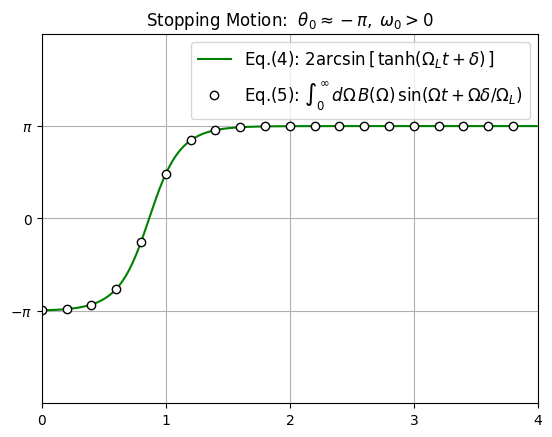

In [8]:
import scipy as sp
import numpy as np

def B(Omega,OmegaL):
    kappa = np.pi/2
    if Omega==0:
        return 2
    else:
        return 2/Omega/np.cosh(kappa*Omega/OmegaL)

def Stopping_FreqDomain(t, delta, OmegaL):
    
    def integrand(Omega,t,delta,OmegaL):
        return B(Omega,OmegaL)*np.sin(Omega*t + Omega*delta/OmegaL)
    
    # extend limit to a large value, say 40*OmegaL
    I = sp.integrate.quad(integrand,0,40*OmegaL,args=(t,delta,OmegaL))
    return I[0]

def Stopping_TimeDomain(t, delta, OmegaL):
    return 2*np.arcsin( np.tanh(OmegaL*t + delta) )

Tmax = 4
t = np.arange(0, Tmax, 0.01)

theta0 = -179/180*np.pi
omegac = 2*OmegaL
omega0 = get_omega0(theta0, omegac, OmegaL)
delta = phase(theta0, omega0, OmegaL)

time_domain = np.zeros(len(t))
freq_domain = np.zeros(len(t))
for i in range(len(t)):
    time_domain[i] = Stopping_TimeDomain(t[i],delta,OmegaL)
    freq_domain[i] = Stopping_FreqDomain(t[i],delta,OmegaL)

plt.plot(t,time_domain,'g-',
    label='Eq.(4): $2\\arcsin\\left[\,\\tanh(\Omega_L t+\\delta)\,\\right]$')
plt.plot(t,freq_domain,'ko',markevery=20,
    markerfacecolor='white',
    label='Eq.(5): $\\int_0^\\infty \, d\\Omega \, B(\Omega) \, \\sin(\\Omega t + \Omega \\delta/\Omega_L)$')
plt.legend(fontsize=12)
plt.xticks([0,1,2,3,4])
plt.yticks([-np.pi,0,np.pi],['$-\pi$','0','$\pi$'])
plt.title('Stopping Motion:  $\\theta_0 \\approx -\pi,\\; \\omega_0 > 0$')
plt.ylim(-2*np.pi,2*np.pi)
plt.xlim(0,4)
plt.grid()
plt.show()